# Changing individual susceptibility

We now turn to countermeasures that we can take to reduce the size of an epidemic.

There are several ways we can approach this. In this chapter we'll look at ways in which we can change an individual's response to potential infection. By making individuals less likely to be infected, we reduce the chances that an encounter will result in secondary infection and therefor reduce the chance of the disease spreading widely. We'll see that it matters *how many* individuals' susceptibility we modifgy, and often *which individuals*. 

(In a  later chapter we'll look at an alternative approach which leaves individual susceptibilities alone but changes the topology of encounters at the population level.)

**Vaccination** changes susceptibility at a **biological** level, by changing an individual's immune response, and in this chapter we'll talk about the ways in which vaccines affect epidemic spreading in a population. But it's important to remember that the same effect can be achieved at a **physical** level, with no vaccine and in fact no biological interventions at all, as we'll {ref}`see later <sec:vaccination-no-vaccine>`. From the perspective of epidemic spreading both biological and physical approaches behave in largely the same way.

## Vaccines

```{margin}

Edgar Allan Poe's short story *The Masque of the Red Death* fictionalises the ineffectiveness of this strategy (especially when faced with a supernatural opponent).
```

For most of history we have been unable to affect the progress of diseases by biological means. Instead, we've been limited to using topology &ndash; isolation and quarantine &ndash; to reduce the spread of a disease, or slow down its progress. For many diseases these approaches were ineffective given the dynamics of the disease and the conditions of daily life for the majority of the population, and even being sufficiently rich to lock oneself away was not guaranteed to spare one from infection. 

This changed at the turn of the nineteenth century with the introduction of vaccines. Vaccination was first tried at scale by Sir Edward Jenner, who realised the similarities between smallpox &ndash; a ravaging disease and a cause of immense suffering &ndash; and cowpox, a far milder complaint commonly encountered by milkmaids who picked it up from cattle. This proved to be the first in a long line of innovations that have now erradicated smallpox entirely. 

Vaccines work by priming a person's immune system so that, if they are later infected, they already have the immunological machinery needed to fight it off. Critically, this reduces the time between infection happening and the immune response starting, meaning that there is less pathogen to fight off and therefore a better chance of preventing the infection taking hold in that individual. Sometimes this can be so effective that the individual is unaware they were even infected; more commonly they suffer a milder version of the disease, with less severe symptoms which they recover from more quickly. 

There are lots of ways to build a vaccine. One can do as Jenner did and use a **variant** of the disease one is interested in. One can take the actual disease and produce a **denatured** version that cannnot cause infection but does nevertheless prime the immune system. Modern vaccines are often even more specific than this, identifying some of the surface proteins that characterise the pathogen and introducing only them as a primer.

Immunology is an immense subject, but fortunately we don't need to understand its mechanics &ndash; how it works in *individuals* &ndash; to understand its epidemiology &ndash; how it works in *populations*. In fact, as we'll see, in some cases we don't need a vaccine to get the *effects* of vaccination. 

## Epidemics on human contact networks

Let's revisit {doc}`human contact networks <hcn>` as a substrate for an epidemic. Such a network resembles a powerlaw-with-cutoff topology rather than the "normal" topology of an {doc}`ER network <er>`: there are nodes that have degrees (contacts) substantially larger than the mean of the network overall. We made the point that such networks are {ref}`very good at spreading diseases <sec:hcn-always-percolate>`. 

How good? Human contact networks have different cutoffs, the point at which the probability of having nodes with higher degrees reduces dramatically. We can explore what this means by picking the dynamics of a disease and varyiong the cutoff top see how the *same* disease propagates on networks with *different* topologies.   

In [1]:
import numpy
import networkx
import epyc
import epydemic
import pandas
import mpmath

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import seaborn
matplotlib.style.use('seaborn')

In [2]:
class MonitoredSIR(epydemic.SIR, epydemic.Monitor):
 
    def __init__(self):
        super(MonitoredSIR, self).__init__()
        
    def build(self, params):
        '''Build the observation process.
        
        :param params: the experimental parameters'''
        super(MonitoredSIR, self).build(params)

        # also monitor other compartments
        self.trackNodesInCompartment(epydemic.SIR.SUSCEPTIBLE)
        self.trackNodesInCompartment(epydemic.SIR.REMOVED)

In [3]:
class PLCNetworkDynamics(epydemic.StochasticDynamics):
    
    # Experimental paramerters
    N = 'N'
    ALPHA = 'alpha'
    CUTOFF = 'cutoff'
    
    def __init__(self, p):
        super(PLCNetworkDynamics, self).__init__(p)

    def makePowerlawWithCutoff(self, alpha, cutoff):
        C = mpmath.polylog(alpha, numpy.exp(-1.0 / cutoff))
        def p(k):
            return (pow((k + 0.0), -alpha) * numpy.exp(-(k + 0.0) / cutoff)) / C
        return p
    
    def generatePLC(self, N, alpha, cutoff, maxdeg=100):
        p = self.makePowerlawWithCutoff(alpha, cutoff)
        rng = numpy.random.default_rng()
        ns = []
        t = 0
        for i in range(N):
            while True:
                k = rng.integers(1, maxdeg)
                if numpy.random.random() < p(k):
                    ns.append(k)
                    t += k
                    break
        while t % 2 != 0:
            i = rng.integers(0, len(ns) - 1)
            t -= ns[i]
            del ns[i]
            while True:
                k = rng.integers(1, maxdeg)
                if numpy.random.random() < p(k):
                    ns.append(k)
                    t += k
                    break
        return networkx.configuration_model(ns, create_using=networkx.Graph())

    def configure(self, params):
        super(PLCNetworkDynamics, self).configure(params)
        
        # build a random powerlaw-with-cutoff network with the given parameters
        N = params[self.N]
        alpha = params[self.ALPHA]
        cutoff = params[self.CUTOFF]
        g = self.generatePLC(N, alpha, cutoff)
        self.setNetworkPrototype(g)

In [4]:
# network parameters
N = 10000
alpha = 2

# simulation time
T = 1000

# disease dynamic parameters
pInfected = 0.001
pInfect = 0.01
pRemove = 0.002

In [5]:
# set up the experiment
lab = epyc.Lab()
lab[epydemic.SIR.P_INFECTED] = pInfected
lab[epydemic.SIR.P_INFECT] = pInfect
lab[epydemic.SIR.P_REMOVE] = pRemove
lab[PLCNetworkDynamics.N] = N
lab[PLCNetworkDynamics.ALPHA] = alpha
lab[PLCNetworkDynamics.CUTOFF] = numpy.linspace(10, 80, num=4)
lab[epydemic.Monitor.DELTA] = T / 50          # take 50 samples

# perform one monitoried epidemic
m = MonitoredSIR()
e = PLCNetworkDynamics(m)
lab.runExperiment(e)

Plotting the results for the different cutroff values yields the following.

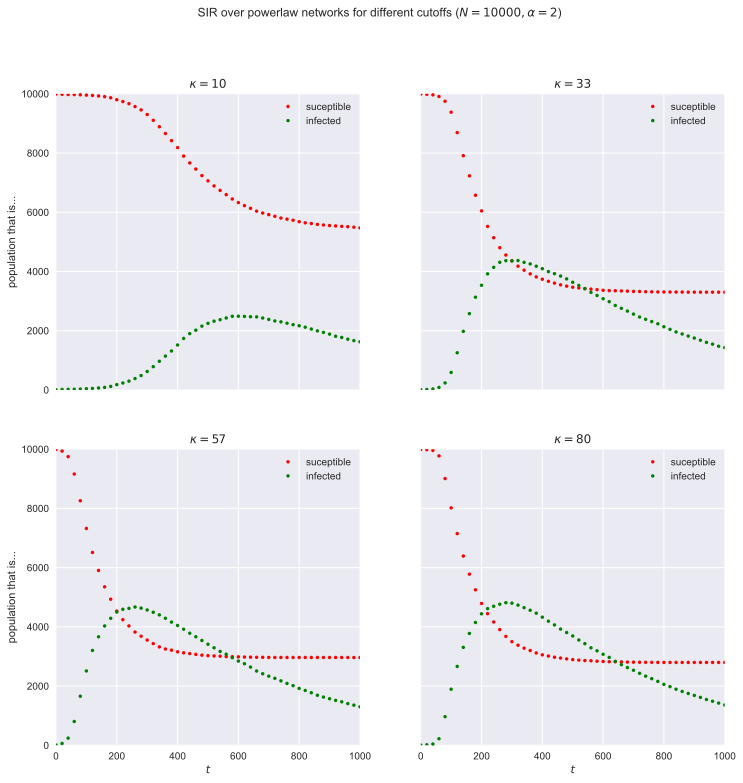

In [22]:
df = lab.dataframe()
cutoffs = df[PLCNetworkDynamics.CUTOFF].unique()

(fig, axs) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 12))

for (ax, cutoff) in [ (axs[0][0], cutoffs[0]),
                      (axs[0][1], cutoffs[1]),
                      (axs[1][0], cutoffs[2]), 
                      (axs[1][1], cutoffs[3]) ]:
    rc = df[df[PLCNetworkDynamics.CUTOFF] == cutoff]
    timeseries = rc[MonitoredSIR.TIMESERIES].iloc[0]
    ts = timeseries[MonitoredSIR.OBSERVATIONS]
    sss = timeseries[epydemic.SIR.SUSCEPTIBLE]
    iss = timeseries[epydemic.SIR.INFECTED]
    rss = timeseries[epydemic.SIR.REMOVED]

    ax.plot(ts, sss, 'r.', label='suceptible')
    ax.plot(ts, iss, 'g.', label='infected')
    #ax.plot(ts, rss, 'ks', label='removed')

    ax.set_title('$\\kappa = {kappa:.0f}$'.format(kappa=cutoff))
    ax.set_xlim([0, T])
    ax.set_ylim([0, N])
    ax.legend(loc='upper right')

# fine-tune the diagram
plt.suptitle('SIR over powerlaw networks for different cutoffs ($N = {n}, \\alpha={a}$)'.format(n=N, a=alpha))
for y in range(2):
    axs[y][0].set_ylabel('population that is...')
for x in range(2):
    axs[1][x].set_xlabel('$t$')

plt.show()

This is telling us that networks with a small maximum number of contacts ($\kappa = 10$) have relative small epidemics that appear quite slowly: the "peak" of the infections occurs farther into the outbreak. As we increase $\kappa$ we see larger epidemics happening faster (closer to the start of the outbreak), until the results seem to stabilise and not change much as we continue to increase $\kappa$: a maximum of about 30 contacts seems to be enough to infect about half the popuation at the peak.

(sec:vaccination-sir)=
## Vaccination in SIR

```{margin}

We've obviously simplified this, as anyone who's caught a disease for which they've been vaccinated will know. Vaccination doesn't always give full immunity against infection.
```

What does vaccination look like in the {doc}`SIR model <continuous>`? A vaccinated individual is one who cannot catch the disease. In model terms it means that an individual who exhibits that characteristics of heving already had the disease, and having been "removed" into the **R** compartment. In fact thisis what's happening biologically as well: a vaccinated individual has been exposed to a substance that renders them as same *as if* they'd had the disease, without actually requiring them to *have had* it. The effect we're looking for is {doc}`herd immunity <herd>`, where there are insufficient susceptible individuals in a population to let the disease establish itelf. But critically we're looking for her immunity *without* having the disease pass through the population first, with all the suffering and (possibly) death that this might entail.

We could model vaccination using a new compartment, leading to a model that might be called **SIVR** capturing the vaccinated individuals. But in conditions of total vaccinated immunity the **V** individuals will behave identically to the **R** individuals, so we may as well simply treat them identically too. (If we were wanting to explore partial immunity through vaccination then SIVR lets us have, for example, different values of $p_{\mathit{infect}}$ depending on whether it's an **S** or a **V** individual being potentially infected: **V** becomes a halfway-house between **S** (fully susceptible) and **R** (fully removed).

(sec:vaccination-random)=
## Vaccinating the population at random

```{margin}

For many years seasonal influenza vaccines were grown in chicken eggs, meaning that they were unsuitable for vegans and anyone with a dairy allergy. Modern flu vaccines aren't created this way.
```

Most vaccines are applied broadly to a population, typically in childhood for a range of common diseases which most people will face. Ideally everyone is vaccinated; in practice some are missed for various reasons, in some the vaccine will not "take", some must avoid it for unrelated medical reasons, and so forth.

We could try to model the ways in which this process happens in detail, but the overall effect is very similar to the case where we take a population and randomly vaccinate some percentage of the individuals before starting the infection. Since this is SIR, this means that we randomly assign some fraction $p_{vaccinated}$ of nodes to the **R** compartment.

In [9]:
class MonitoredVaccinatedSIR(epydemic.SIR, epydemic.Monitor):
    
    P_VACCINATED = 'pVaccinated'   #: Probability that an individual is initially removed.
    
    def __init__(self):
        super(MonitoredVaccinatedSIR, self).__init__()
        
    def build(self, params):
        '''Build the observation process.
        
        :param params: the experimental parameters'''
        super(MonitoredVaccinatedSIR, self).build(params)

        # change the initial compartment probabilities to vaccinate (remove) some fraction
        pInfected = params[epydemic.SIR.P_INFECTED]
        pVaccinated = params[self.P_VACCINATED]
        self.changeCompartmentInitialOccupancy(epydemic.EIR.INFECTED, pInfected)
        self.changeCompartmentInitialOccupancy(epydemic.SIR.REMOVED, pVaccinated)
        self.changeCompartmentInitialOccupancy(epydemic.SIR.SUSCEPTIBLE, 1.0 - pInfected - pVaccinated)

        # also monitor other compartments
        self.trackNodesInCompartment(epydemic.SIR.SUSCEPTIBLE)
        self.trackNodesInCompartment(epydemic.SIR.REMOVED)

We can choose any number we like for $p_{vaccinated}$, with 60% being a typical target for immunisation campaigns.

In [23]:
pVaccinated = 0.6

Leaving all other experimental parameters the same frmm above, let's choose a value of $\kappa=57$ as a cutoff that we saw created an epidemic in a unvaccinated population, and run an experiment where we first vaccinate (remove) a fraction of nodes at random.

In [10]:
lab[MonitoredVaccinatedSIR.P_VACCINATED] = pVaccinated
lab[PLCNetworkDynamics.CUTOFF] = 57

m = MonitoredVaccinatedSIR()
e = PLCNetworkDynamics(m)
lab.runExperiment(e)

df = lab.dataframe()

We can then see the progress of the *same* epidemic on the *same* network topology, but in the presence of an effective vaccine applied to a fraction of the population.

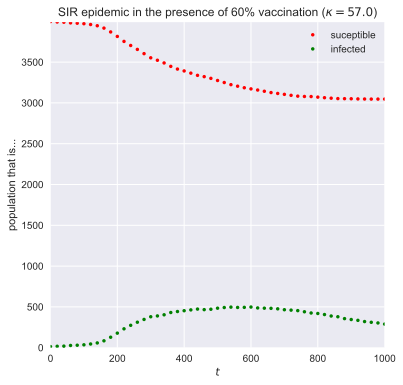

In [24]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

rc = df[df[MonitoredVaccinatedSIR.P_VACCINATED] == 0.6]
results = rc.iloc[0]
timeseries = results[epydemic.Monitor.TIMESERIES]
ts = timeseries[MonitoredVaccinatedSIR.OBSERVATIONS]
sss = timeseries[epydemic.SIR.SUSCEPTIBLE]
iss = timeseries[epydemic.SIR.INFECTED]
rss = timeseries[epydemic.SIR.REMOVED]
ax.plot(ts, sss, 'r.', label='suceptible')
ax.plot(ts, iss, 'g.', label='infected')
#ax.plot(ts, rss, 'ks', label='removed')

ax.set_xlim([0, T])    
ax.set_xlabel('$t$')
ax.set_ylim([0, N * (1.0 - pVaccinated - pInfected)])
ax.set_ylabel('population that is...')
ax.set_title('SIR epidemic in the presence of {v:.0f}% vaccination ($\\kappa = {k}$)'.format(v=results[MonitoredVaccinatedSIR.P_VACCINATED] * 100, k=results[PLCNetworkDynamics.CUTOFF]))
ax.legend(loc='upper right')

plt.show()

Compariong this to the figure above shows quite a dramatic reduction in the outbreak size.

But wait! &ndash; there's a problem. Look at the y-axis in this graph. Notice that the maximum susceptible population is about 4000, even though the network has 10000 nodes. A moment's thought shows why: we modelled vaccination as being  pre-emptively removed, leaving fewer susceptibles. Could it be that this result is what we'd *expect* on a smaller network? In other words, is there a size effect coming into play as we move from 10000 down to 4000 individuals?

We should be careful and check this possibility. We can do so by working out the size of the unvaccinated population and creating a network with the same topology of this size, and then running our epidemic over it.

In [36]:
Nsmall = int(N * (1.0 - pVaccinated - pInfected))
lab[PLCNetworkDynamics.N] = Nsmall

m = MonitoredSIR()
e = PLCNetworkDynamics(m)
lab.runExperiment(e)
df = lab.dataframe()

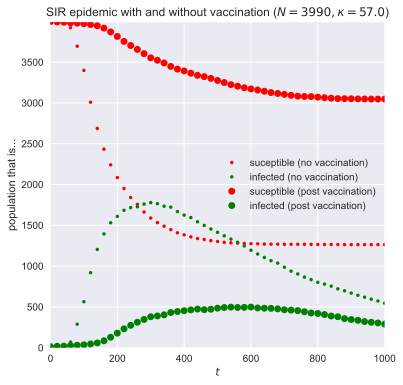

In [73]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

# plot epidemic on unvaccinated network
rc = df[df[PLCNetworkDynamics.N] == Nsmall]
results = rc.iloc[0]
timeseries = results[epydemic.Monitor.TIMESERIES]
ts = timeseries[MonitoredVaccinatedSIR.OBSERVATIONS]
sss = timeseries[epydemic.SIR.SUSCEPTIBLE]
iss = timeseries[epydemic.SIR.INFECTED]
rss = timeseries[epydemic.SIR.REMOVED]
ax.plot(ts, sss, 'r.', label='suceptible (no vaccination)')
ax.plot(ts, iss, 'g.', label='infected (no vaccination)')
#ax.plot(ts, rss, 'ks', label='removed')

# plot results on same-sized network reduced in size by vaccination
rc = df[df[MonitoredVaccinatedSIR.P_VACCINATED] == 0.6]
results = rc.iloc[0]
timeseries = results[epydemic.Monitor.TIMESERIES]
ts = timeseries[MonitoredVaccinatedSIR.OBSERVATIONS]
sss = timeseries[epydemic.SIR.SUSCEPTIBLE]
iss = timeseries[epydemic.SIR.INFECTED]
rss = timeseries[epydemic.SIR.REMOVED]
ax.plot(ts, sss, 'ro', label='suceptible (post vaccination)')
ax.plot(ts, iss, 'go', label='infected (post vaccination)')
#ax.plot(ts, rss, 'ks', label='removed')
ax.set_xlim([0, T])    
ax.set_xlabel('$t$')
ax.set_ylim([0, Nsmall])
ax.set_ylabel('population that is...')
ax.set_title('SIR epidemic with and without vaccination ($N = {n}, \\kappa = {k}$)'.format(n=Nsmall, k=results[PLCNetworkDynamics.CUTOFF]))
ax.legend(loc='center right')

plt.show()

The first thing to see is that the two graphs are different: it's not *just* the size of the network that affets things. In the small-but-unvaccinated network we see a very small epidemic; in the vaccinated network we see a much larger and faster outbreak.

This seems strange: what's different between the two cases, since we've eliminated network size as a variable?

A moment's thought may siggest the answer. We've created two networks with the same topology, one where a fraction of nodes are removed by vaccination, and one where a number of nodes really had been removed (or rather, were never present in the network in the first place). The both networks have high-degree nodes, as we'd expect for powerlaw-with-cutoff networks. But in the latter (vaccinated) case, some of those high-degree nodes wil have been vaccinated and so not be able to spread the disease. And since the disease spreads through contact between **S** and **I** nodes, we lose the opportunity to infect a high-degree node that could act as a **super-spreader** able to infect a large number of nodes.

(sec:vaccination-superspreaders)=
## Super-spreaders

Let's look at some numbers. Firstly, how many contacts does the most highly-connected node have?

In [43]:
g = m.network()
ks = sorted(list(dict(networkx.degree(g)).values()))
print('Maximum degree = {kmax}'.format(kmax=max(ks)))

Maximum degree = 96


That's a high number. What about the number of contacts for an averagely-connected node?

In [75]:
print('Mean node degree = {kmean}'.format(kmean=numpy.mean(ks)))

Mean node degree = 2.5518796992481203


*Very* different, and it's this feature that differentiates a human contact network from an ER network: the existence of nodes with degrees that are much higher than the average. In fact such networks have a **long tail** of nodes with high degrees: only a small number relative to the size of the network overall, but nonetheless able to pass infection.

In [48]:
h = 10
print('Highest {h} nodes by degree {l}'.format(h=h, l=ks[-h:]))

Highest 10 nodes by degree [44, 49, 53, 54, 59, 59, 75, 79, 87, 96]


```{margin}

There are other ways we could do this too, for example by making the probability of vaccinating a node inversely proportional to its degree.
```

How important are these individuals in the spread of the disease? We can study that by excluding them from our model vaccination programme. Instead of vaccinating some fraction of the network, after vaccination we will make sure that some fraction of the highest-degree nodes are susceptible. Essentially we swap high-degree nodes for lower-degree nodes in our vaccination programme.

In [76]:
class MonitoredVaccinatedLowDegreeSIR(MonitoredVaccinatedSIR):

    K_HIGH_FRACTION = 'k_high_fraction'
    
    def __init__(self):
        super(MonitoredVaccinatedLowDegreeSIR, self).__init__()
        
    def setUp(self, params):
        super(MonitoredVaccinatedLowDegreeSIR, self).setUp(params)
        
        # look through the fraction of high-degree nodes and make them susceptible again,
        # replacing them with another node chosen at random
        rng = numpy.random.default_rng()
        g = self.network()
        ns = list(g.nodes())
        h = int(len(ns) * params[self.K_HIGH_FRACTION])
        degrees = dict(networkx.degree(g))
        ks = sorted(list(degrees.values()))
        ks_high = set(ks[-h:])
        ns_high = [n for n in ns if degrees[n] in ks_high]
        for n in ns_high:
            if self.getCompartment(n) == self.REMOVED:
                # node is removed, make it susceptible again
                self.setCompartment(n, self.SUSCEPTIBLE)
                
                # choose another node and remove it in place of
                # the node we just forced to be susceptible
                while True:
                    i = rng.integers(0, len(ns) - 1)
                    m = ns[i]
                    if self.getCompartment(m) == self.SUSCEPTIBLE:
                        # found a susceptible node, remove it
                        self.setCompartment(m, self.REMOVED)
                        break

Running the experiment, again with the same disease parameters and network topology as before, shows us the effects of this failure in vaccination.

In [77]:
kHighFraction = 0.08        # keep highest-degree 10% susceptible

lab[MonitoredVaccinatedLowDegreeSIR.K_HIGH_FRACTION] = kHighFraction
lab[PLCNetworkDynamics.N] = N

m = MonitoredVaccinatedLowDegreeSIR()
e = PLCNetworkDynamics(m)
lab.runExperiment(e)
df = lab.dataframe()

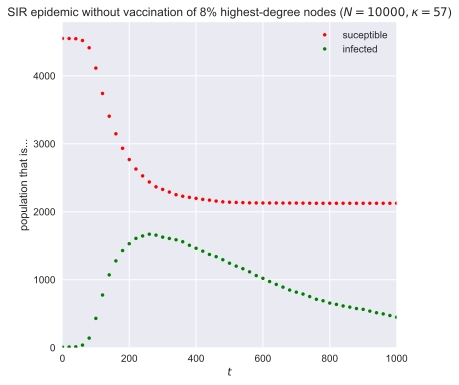

In [79]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

rc = df[df[MonitoredVaccinatedLowDegreeSIR.K_HIGH_FRACTION] == kHighFraction]
results = rc.iloc[0]
timeseries = results[epydemic.Monitor.TIMESERIES]
ts = timeseries[MonitoredVaccinatedSIR.OBSERVATIONS]
sss = timeseries[epydemic.SIR.SUSCEPTIBLE]
iss = timeseries[epydemic.SIR.INFECTED]
rss = timeseries[epydemic.SIR.REMOVED]
ax.plot(ts, sss, 'r.', label='suceptible')
ax.plot(ts, iss, 'g.', label='infected')
#ax.plot(ts, rss, 'ks', label='removed')

ax.set_xlim([0, T])    
ax.set_xlabel('$t$')
ax.set_ylim([0, N * (1.0 - pInfected - pVaccinated) + N * kHighFraction])
ax.set_ylabel('population that is...')
ax.set_title('SIR epidemic without vaccination of {khigh:.0f}% highest-degree nodes ($N = {n}, \\kappa = {k:.0f}$)'.format(khigh=kHighFraction * 100, n=N, k=results[PLCNetworkDynamics.CUTOFF]))
ax.legend(loc='upper right')

plt.show()

Letting a small fraction of the high-degree nodes &ndash; *i.e.*, the most connected individuals &ndash;  remain susceptible changes the epidemic again, making it much larger. It's not only the *size* of the vaccinated population that counts: it's *who we vaccinate* (or, in this case, don't vaccinate) that really matters. Missing even a small fraction of the highly connected will radically reduce the effectiveness of a vaccination programme.

(sec:vaccination-countermeasure)=
## Targetted vaccination

So the existence of high-degree nodes offers an opportunity for the disease to infect far more individuals than it can on average of those nodes remain susceptible to infection.

But this also offer opportunities for countermeasures. If high-degree nodes are importantin spreading the disease, whet if &ndash; instead of vaccinating at random &ndash; we instead *explicitly target* those nodes that we believe are the most important in spreading the disease? That might make our programme more effective. It might also mean that we could perform a smaller, more focused, programme, where instead of vaccinating widely at random we vaccinate narrowly but in a focused, "smart" way.

We can explore this too. Rather than perform random vaccination, we instead target a specific fraction of the highest-degree nodes. 

In [85]:
class MonitoredVaccinatedHighDegreeSIR(MonitoredSIR):

    K_VACCINATED_FRACTION = 'k_vaccinated_fraction'
    
    def __init__(self):
        super(MonitoredVaccinatedHighDegreeSIR, self).__init__()
        
    def setUp(self, params):
        super(MonitoredVaccinatedHighDegreeSIR, self).setUp(params)

        # look for the fraction of highest-degree nodes and vaccinate (remove) them
        g = self.network()
        ns = list(g.nodes())
        h = int(len(ns) * params[self.K_VACCINATED_FRACTION])
        degrees = dict(networkx.degree(g))
        ks = sorted(list(degrees.values()))
        ks_high = set(ks[-h:])
        ns_high = [n for n in ns if degrees[n] in ks_high]
        for n in ns_high:
            # remove (vaccinate) the node
            self.setCompartment(n, self.REMOVED)

How large a fraction do we need to target? Let's be ambitious and start small, vaccinating only 2% of nodes &ndash; thirty times fewer than before.

In [90]:
kVaccinatedFraction = 0.02        # vaccinate only the top 2% highest-degree nodes
lab[MonitoredVaccinatedHighDegreeSIR.K_VACCINATED_FRACTION] = kVaccinatedFraction

m = MonitoredVaccinatedHighDegreeSIR()
e = PLCNetworkDynamics(m)
lab.runExperiment(e)
df = lab.dataframe()

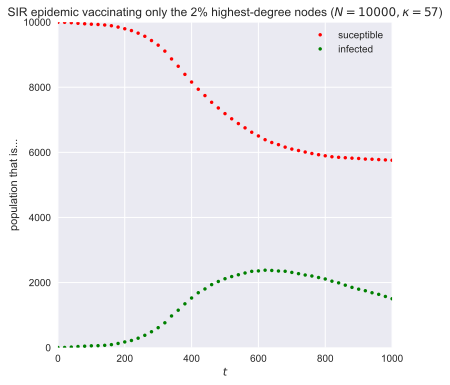

In [92]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

rc = df[df[MonitoredVaccinatedHighDegreeSIR.K_VACCINATED_FRACTION] == kVaccinatedFraction]
results = rc.iloc[0]
timeseries = results[epydemic.Monitor.TIMESERIES]
ts = timeseries[MonitoredVaccinatedSIR.OBSERVATIONS]
sss = timeseries[epydemic.SIR.SUSCEPTIBLE]
iss = timeseries[epydemic.SIR.INFECTED]
rss = timeseries[epydemic.SIR.REMOVED]
ax.plot(ts, sss, 'r.', label='suceptible')
ax.plot(ts, iss, 'g.', label='infected')
#ax.plot(ts, rss, 'ks', label='removed')

ax.set_xlim([0, T])    
ax.set_xlabel('$t$')
ax.set_ylim([0, N])
ax.set_ylabel('population that is...')
ax.set_title('SIR epidemic vaccinating only the {kvac:.0f}% highest-degree nodes ($N = {n}, \\kappa = {k:.0f}$)'.format(kvac=kVaccinatedFraction * 100, n=N, k=results[PLCNetworkDynamics.CUTOFF]))
ax.legend(loc='upper right')

plt.show()

That's quite amazing! With almost no-one vaccinated &ndash; 200 in a network of 10000 &ndash; we both reduce and slow the epidemic. Both these effects are important. The total number of people infected is smaller, but so too is the "ramp-up" at the start of the epidemic, which means less stress is placed on health systems dealing with the influx of sick peoiple.

When people talk of **flattening the curve**, this is the effect they're aiming at &ndash; achieved in this case through targeted vaccination of a tiny fraction of the population.

This reduction in vaccination effort makes it faster, cheaper, and more reliable &ndash; *if* we can identify and target the super-spreaders. But this might be possible, because we know that the super-spreaders are the highest-degree nodes, who are simply the ones with the most exposure to other people. In the modern world a person's contact degree is often at least partially a function of their job, and so by targetiong those whose jobs bring them into contact with the most people &ndash; and epseically into contact with the most *infected* people &ndash; we can create a very effective vaccination strategy and roll it out quickly.  

(sec:vaccination-no-vaccine)=
## "Vaccination" without vaccines

We said at the beginning of this chapter that immunology was an enormously complicated topic but one whose details didn't matter for population-level modelling. The experiments we conducted above have hopefully convinced you of this.

But if this is the case, then it's not vaccination that's the important feature for our purposes. Any technology that behaves *like* a vaccine, preventing the infection of those we treat, will have the same effect.

What technologies might these be? An obvious example is personal protective equipment such as face masks, surgical gloves, and the like, issued to those whom we identify as being in high-contact professions such as care workers, medical workers, bus drivers, and the like &ndash; anyone who, if they were to become infected, would have the potential to spread the disease to a disproportionate number of others. Most importantly this doesn't require that we protect *everyone*, just that we protect *the most important* nodes in the contact network, whom we identify by their contact degree.